<a href="https://colab.research.google.com/github/vkthakur90/AI_Applications/blob/master/cifar_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np

In [2]:
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import tensorflow.keras.models as tfkm
import tensorflow.keras.utils as tfku

In [3]:
(train_x, train_y), (test_x, test_y) = tfk.datasets.cifar10.load_data()

In [4]:
N, H, W, C = train_x.shape

In [5]:
num_classes = train_y.max() + 1

In [6]:
class LaplacianOfGaussianFilter(tfkl.Layer):
    def __init__(self, dilation_rate, **kwds):
        super().__init__(**kwds)
        self.dilation_rate = dilation_rate

    def build(self, input_shape):
        laplacian_kernel = np.array([
            [ 0.0, -1.0,  0.0],
            [-1.0,  4.0, -1.0],
            [ 0.0, -1.0,  0.0]
        ])

        gaussian_kernel = (1.0/16.0) * np.array([
            [1.0, 2.0, 1.0],
            [2.0, 4.0, 2.0],
            [1.0, 2.0, 1.0]
        ])

        inp = tfkl.Input(input_shape[1:])

        x = inp

        gaussian_filter = tfkl.DepthwiseConv2D(kernel_size = (3, 3), dilation_rate = self.dilation_rate, padding = 'same', use_bias = False)
        laplacian_filter = tfkl.DepthwiseConv2D(kernel_size = (3, 3), dilation_rate = self.dilation_rate, padding = 'same', use_bias = False)

        x = gaussian_filter(x)
        x = laplacian_filter(x)
        x = tfkl.ReLU()(x)

        gaussian_filter.set_weights([np.stack([gaussian_kernel]*input_shape[-1], axis = -1)[..., np.newaxis]])
        laplacian_filter.set_weights([np.stack([laplacian_kernel]*input_shape[-1], axis = -1)[..., np.newaxis]])

        out = x

        self.forward = tfkm.Model(inputs = [inp], outputs = [out])

    def call(self, input):
        return self.forward(input)


In [7]:
def create_encoder():
    inp = tfkl.Input([32, 32, 3])

    x = inp
    x = tfkl.Rescaling(scale = 1./127.5, offset = -1)(x)

    for _ in range(5):
        res = x

        x = res
        x = LaplacianOfGaussianFilter(dilation_rate = (1, 1))(x)
        x1 = x

        x = res
        x = LaplacianOfGaussianFilter(dilation_rate = (2, 2))(x)
        x2 = x

        x = res
        x = LaplacianOfGaussianFilter(dilation_rate = (3, 3))(x)
        x3 = x

        x = res
        x = LaplacianOfGaussianFilter(dilation_rate = (4, 4))(x)
        x4 = x

        x = tfkl.Concatenate(axis = -1)([res, x1, x2, x3, x4])
        x = tfkl.MaxPool2D((2, 2))(x)

    out = x

    model = tfkm.Model(inputs = [inp], outputs = [out], name = 'encoder')

    return model

In [8]:
encoder_model = create_encoder()

In [9]:
encoder_model.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 32, 32, 3)            0         ['input_1[0][0]']             
                                                                                                  
 laplacian_of_gaussian_filt  (None, 32, 32, 3)            54        ['rescaling[0][0]']           
 er (LaplacianOfGaussianFil                                                                       
 ter)                                                                                             
                                                                                            

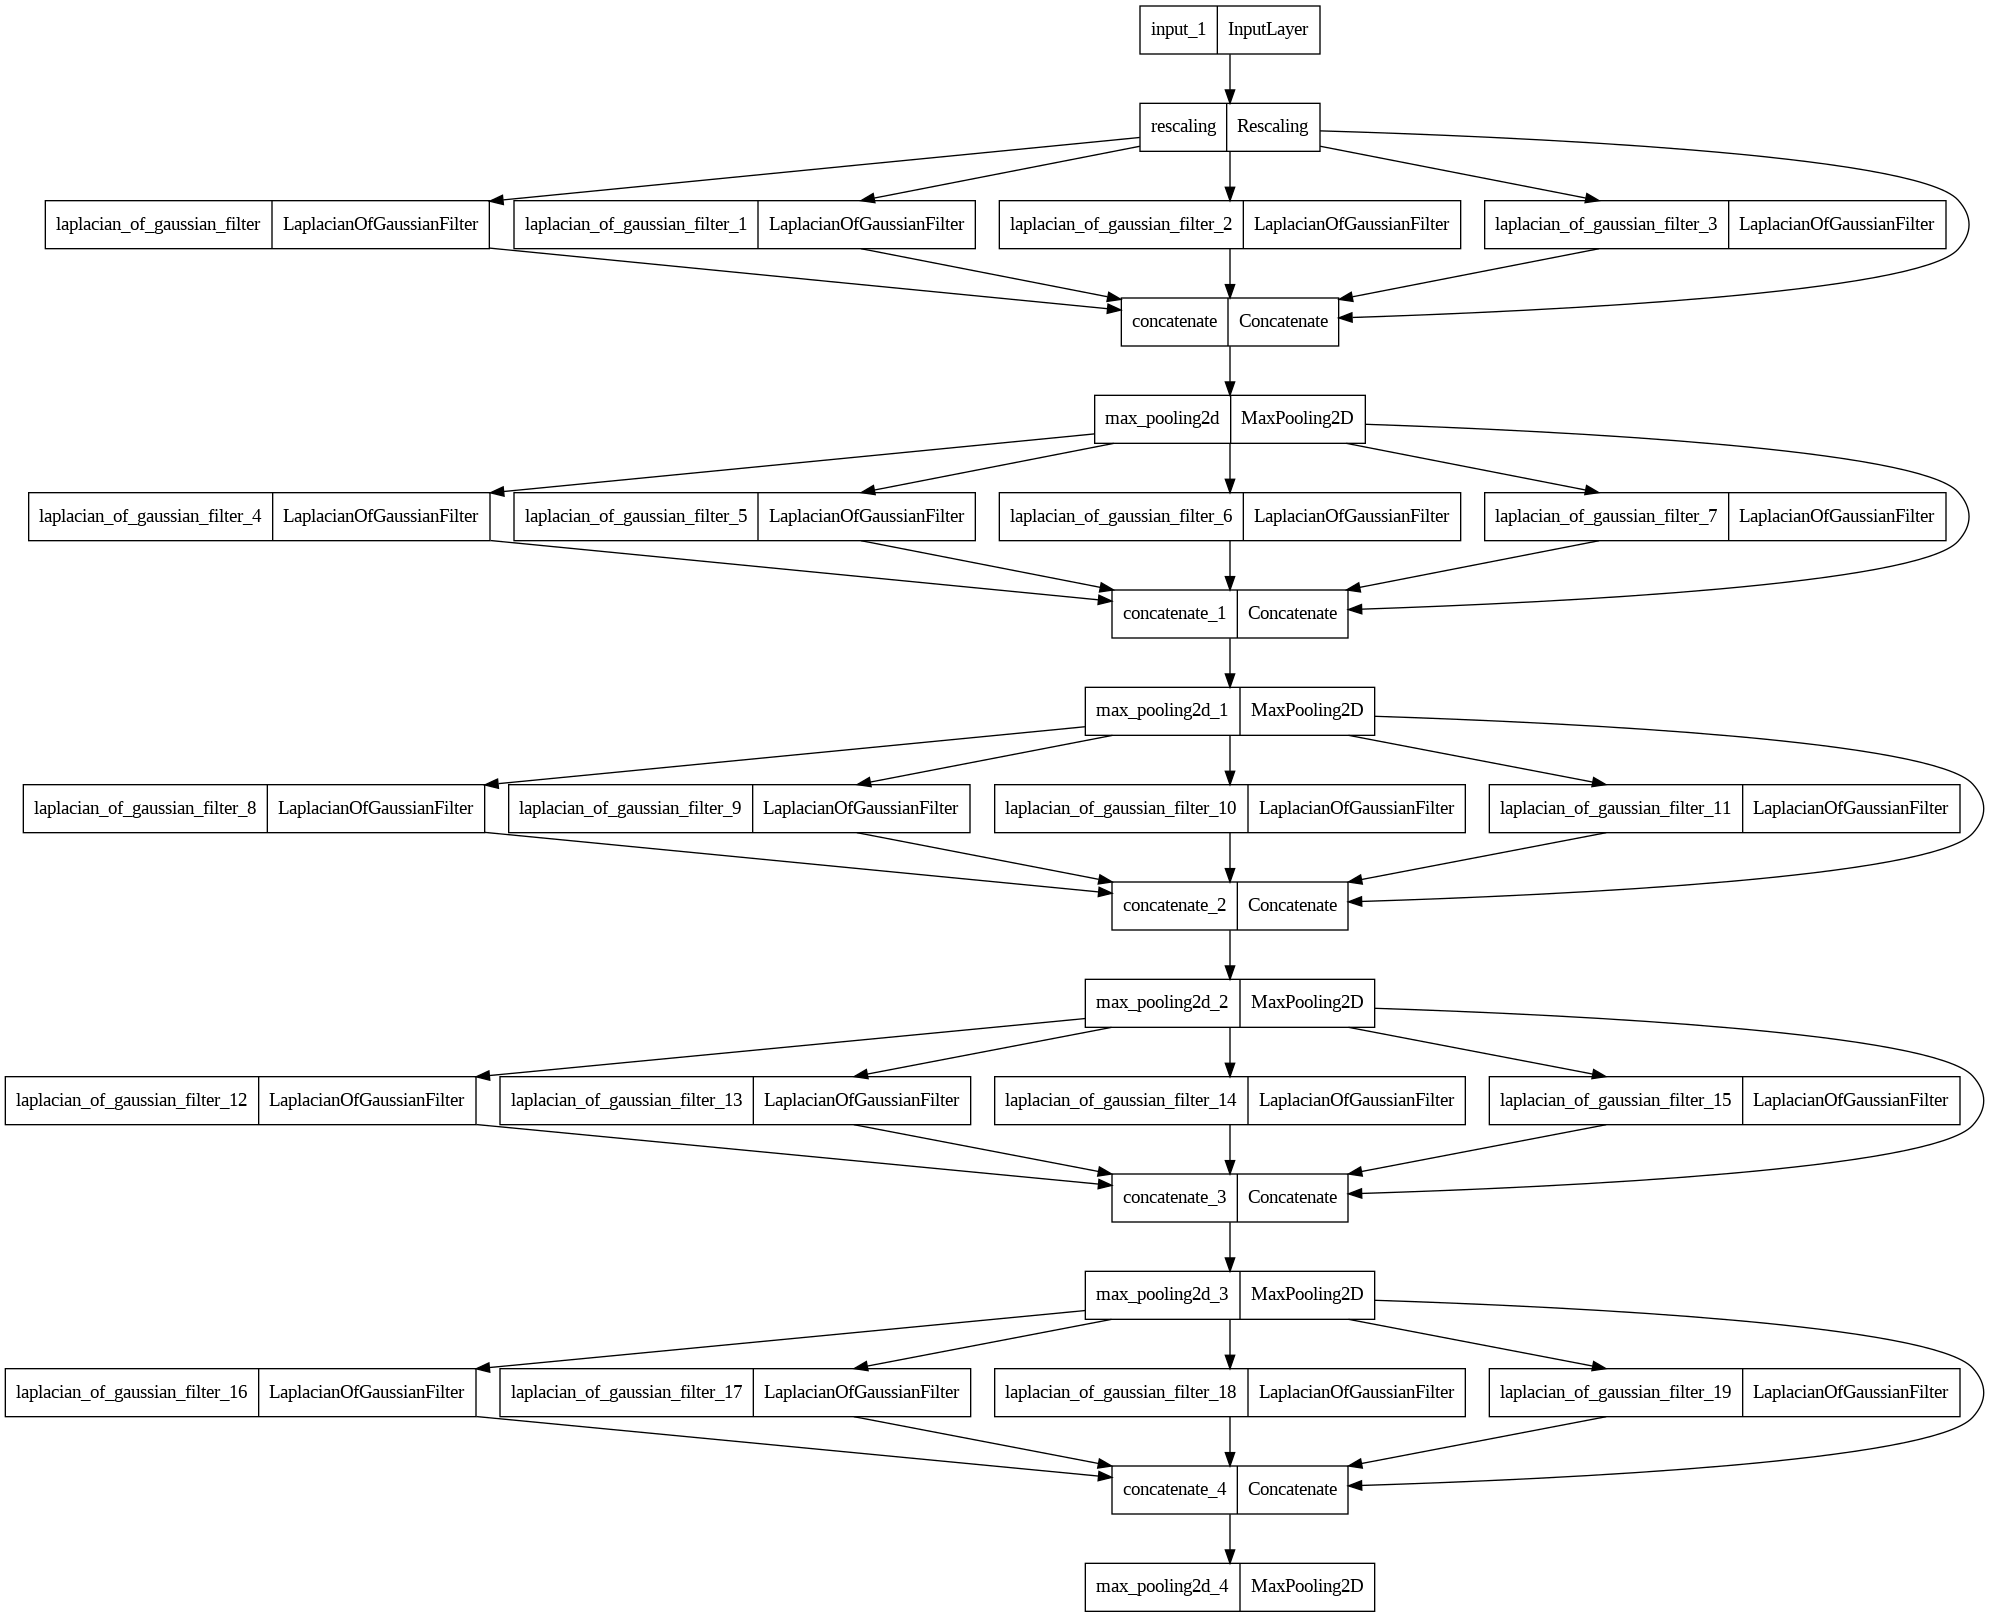

In [10]:
tfku.plot_model(encoder_model)

In [11]:
classifier = tfkm.Sequential([
    tfkl.InputLayer(input_shape = [32, 32, 3]),
    encoder_model,
    tfkl.GlobalAvgPool2D(),
    tfkl.Dense(10, activation = 'softmax')
])

In [12]:
classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Functional)        (None, 1, 1, 9375)        168696    
                                                                 
 global_average_pooling2d (  (None, 9375)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 10)                93760     
                                                                 
Total params: 262456 (1.00 MB)
Trainable params: 262456 (1.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
classifier.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [14]:
cb = classifier.fit(x = train_x, y = train_y, epochs = 5, shuffle = True, batch_size = 8)

Epoch 1/5
6250/6250 [==============================] - 302s 47ms/step - loss: 1.6307 - accuracy: 0.4274
Epoch 2/5
6250/6250 [==============================] - 292s 47ms/step - loss: 1.2828 - accuracy: 0.5565
Epoch 3/5
6250/6250 [==============================] - 292s 47ms/step - loss: 1.1873 - accuracy: 0.5914
Epoch 4/5
6250/6250 [==============================] - 292s 47ms/step - loss: 1.1233 - accuracy: 0.6135
Epoch 5/5
6250/6250 [==============================] - 292s 47ms/step - loss: 1.0790 - accuracy: 0.6297


In [18]:
classifier.evaluate(x = test_x, y = test_y)

313/313 [==============================] - 4s 9ms/step - loss: 1.1118 - accuracy: 0.6177


[1.111797571182251, 0.6176999807357788]

In [16]:
tf.saved_model.save(classifier, export_dir = 'cifar_classification')

In [17]:
!zip -r cifar_classification.zip cifar_classification

  adding: cifar_classification/ (stored 0%)
  adding: cifar_classification/fingerprint.pb (stored 0%)
  adding: cifar_classification/assets/ (stored 0%)
  adding: cifar_classification/saved_model.pb (deflated 93%)
  adding: cifar_classification/variables/ (stored 0%)
  adding: cifar_classification/variables/variables.index (deflated 76%)
  adding: cifar_classification/variables/variables.data-00000-of-00001 (deflated 49%)
